Esteban Schmitt  
CS559   
Assignment 1 Linear Regression   
I pledge my honor that I have abided by the Stevens Honor System

Import and set up data features and Price output

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

X = pd.DataFrame(housing.data,columns=housing.feature_names)
y = pd.DataFrame(housing.target,columns=['PRICE'])

X.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Split the dataset into 70-20-10 train test validate respectively

In [2]:
def manual_train_test_validate_split(X,y,test_size=0.2,validate_size = 0.1):

    num_data_points = X.shape[0]

    shuffled_indices = np.random.permutation(num_data_points)
    
    test_set_size = int(num_data_points*test_size)
    validate_size = int(num_data_points * validate_size)

    test_indices = shuffled_indices[:test_set_size]
    validate_indices=shuffled_indices[test_set_size:test_set_size+validate_size]
    train_indices = shuffled_indices[test_set_size+validate_size:]

    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    X_validate = X.iloc[validate_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    y_validate = y.iloc[validate_indices]


    return X_train, X_test,X_validate, y_train, y_test,y_validate


X_train, X_test,X_validate,y_train, y_test,y_validate = manual_train_test_validate_split(X, y, test_size=0.2)

Add the 0's for bias into the train,test and validate 

In [3]:
X_train_intercept = np.column_stack([np.ones(X_train.shape[0]), X_train])
X_test_intercept = np.column_stack([np.ones(X_test.shape[0]), X_test])
X_validate_intercept = np.column_stack([np.ones(X_validate.shape[0]), X_validate])

Use the closed form solution for w 

In [4]:
XtX = np.dot(X_train_intercept.T,X_train_intercept) #X^T * X
XtX_inv = np.linalg.inv(XtX)
XtY = np.dot(X_train_intercept.T,y_train)

w = np.dot(XtX_inv,XtY)


Get the MSE for the closed form solution

In [5]:
y_pred_test = np.dot(X_test_intercept,w)
mse = np.mean((y_pred_test-y_test)**2)
print(f"MSE: {mse}")

MSE: 0.5322623689290967


Standardize the data for SGD

In [6]:
def standardize(X_train, X_test,X_val):
    # Calculate the mean and standard deviation of the training set
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # To prevent division by zero, set std=1 where std is zero
    std[std == 0] = 1

    # Standardize the training set
    X_train_scaled = (X_train - mean) / std

    # Use the training set's mean and std to standardize the test set
    X_test_scaled = (X_test - mean) / std

    


    X_val_scaled = (X_val - mean)/std

    return X_train_scaled, X_test_scaled,X_val_scaled

In [7]:
X_train_scaled, X_test_scaled,X_validate_scaled = standardize(X_train.values, X_test.values,X_validate.values)


Add zeros for bias 

In [8]:
# Add intercept term to the standardized data
X_train_intercept_scaled = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
X_test_intercept_scaled = np.column_stack([np.ones(X_test_scaled.shape[0]), X_test_scaled])
X_validate_intercept_scaled =np.column_stack([np.ones(X_validate_scaled.shape[0]), X_validate_scaled])


Create the SGD function

In [9]:
# SGD implementation
def sgd(X, y,X_val,y_val, learning_rate=0.01, n_iterations=100):
    m, n = X.shape
    theta = np.random.randn(n, 1)  # Initialize theta with random values
    y = y.values.reshape(-1, 1)    # Reshape y to be a column vector
    type(y)
    y_val=y_val.values.reshape(-1,1) # reshape validation 

    mse_history = []  # List to store MSE values over iterations
    validation_loss = [] # validation loss MSE list

    for iteration in range(n_iterations):

        for i in range(m):
            random_index = np.random.randint(m)
            
            Xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = 2 * Xi.T.dot(Xi.dot(theta) - yi)
            theta = theta - learning_rate * gradients

        # Store MSE for every iteration
        train_mse = np.mean((X.dot(theta) - y) ** 2)
        mse_history.append(train_mse)

        val_mse = np.mean((X_val.dot(theta)-y_val)**2)
        validation_loss.append(val_mse)
        

        if iteration % 50 == 0 and iteration != 0:
            print(f"Epoch: {iteration}")

    return theta, mse_history,validation_loss

Get theta by running sgd

In [10]:
# Train the model using SGD
# model seems to flatten out at 250 iterations so we keep it there
theta_sgd, train_mse_history,val_mse_history = sgd(X_train_intercept_scaled, y_train,X_validate_intercept_scaled,y_validate, learning_rate=0.00001, n_iterations=250)

Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200


MSE for the test set

In [11]:
y_pred_sgd = np.dot(X_test_intercept_scaled, theta_sgd)
# Mean Squared Error for test
mse_sgd = np.mean((y_pred_sgd - y_test.values) ** 2)
print(f"SGD Mean Squared Error on Test: {mse_sgd}")



SGD Mean Squared Error on Test: 0.5315371235574644


## Training and Validation loss curves

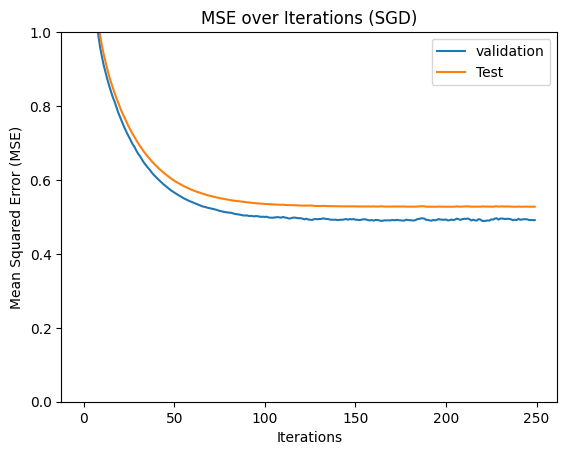

In [12]:
# Plot MSE over iterations

plt.plot(val_mse_history, label = "validation")
plt.plot(train_mse_history,label ="Test")
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE over Iterations (SGD)')
plt.legend(loc='upper right')
plt.ylim(0,1)
plt.show()